In [67]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [69]:
# HYPER PARAMETERS

batch_size = 128
num_epochs = 100
random_seed = 42
test_size = 0.05
learning_rate = 1e-3
total_features = 704

In [70]:
df_image = pd.read_csv('im_embeds_all300k.csv')
df_rest = pd.read_csv('Final_input_without_Img_embedding.csv')
df_errors = pd.read_csv('im_embeds_errors_all300k.csv')
to_be_deleted = list(df_errors['0'])
df_rest.drop(to_be_deleted,inplace=True)
df_rest.reset_index(drop=True,inplace=True)
df_rest_temp = df_rest.dropna(axis=1, how='any')
df_rest_temp

,January,February,March,April,May,June,July,August,September,October,...,27.8,28.6,28.8,29.6,29.8,30.6,30.8,31.6,31.8,likes
0,0,0,0,0,0,0,0,0,0,0,...,-0.007212,1.014997,0.035538,-1.545867,-0.000829,-0.691397,-0.024089,-0.831907,-0.010203,1
1,0,0,0,0,0,1,0,0,0,0,...,-0.013411,-0.059734,0.008625,-0.008493,0.048716,-0.001403,-0.037191,0.017013,-0.004296,2750
2,0,0,0,0,0,0,0,0,1,0,...,0.018361,0.128244,0.034831,-0.035135,0.046096,0.001906,-0.037285,0.001735,-0.002121,57
3,0,0,0,0,0,0,0,0,0,1,...,0.013616,-0.347948,-0.046577,0.228142,0.036993,-0.067138,0.011416,-0.093506,0.004011,152
4,0,0,0,0,0,0,0,0,0,1,...,0.021757,-0.059734,-0.009485,-0.008493,0.027996,-0.001403,0.015712,0.017013,-0.005038,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295568,0,0,0,0,0,0,0,0,1,0,...,0.017732,0.032348,0.004959,-0.038293,-0.032024,0.002040,0.015522,-0.011169,0.060232,0
295569,0,1,0,0,0,0,0,0,0,0,...,-0.012335,0.156163,0.058726,0.033617,-0.038409,-0.049654,-0.014553,-0.040862,0.014289,46
295570,0,0,0,0,0,0,0,0,0,0,...,0.027571,-0.271534,0.045534,0.075950,0.013581,-0.061556,-0.011162,0.003064,-0.038035,261
295571,0,0,0,0,0,0,0,0,0,1,...,0.008562,0.032348,0.024369,-0.038293,0.003715,0.002040,-0.016958,-0.011169,0.015464,119


In [71]:
df_image.drop(['Unnamed: 0'], axis=1, inplace=True)
df_image

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.126831,0.491699,-0.048615,0.266113,0.446289,-0.708008,0.560547,0.472412,0.166748,0.595703,...,-0.296387,0.231689,-0.171997,0.044220,-0.131592,0.441895,0.123047,0.318604,-0.005260,-0.028809
1,-0.002289,0.313721,-0.461426,0.191406,-0.361572,0.117859,-0.204712,0.558594,-0.088806,0.498535,...,0.138306,-0.169189,0.043549,0.015587,-0.220947,-0.436035,-0.275879,0.244141,-0.082642,0.199097
2,-0.028671,-0.220215,-0.000583,-0.280518,0.505371,-0.867188,-0.128540,0.026566,-0.115967,0.082458,...,0.376953,0.444092,-0.296387,-0.458252,-0.251709,-0.353760,0.401123,0.008011,-0.091980,0.050354
3,0.179565,-0.107056,0.148193,-0.283447,-0.042694,-0.725586,0.185913,0.205322,0.394775,0.139282,...,0.015266,-0.092834,-0.345947,-0.076782,-0.614746,-0.084290,-0.310059,0.819336,-0.333984,0.205688
4,-0.211670,-0.013672,-0.369629,-0.050629,-0.299805,0.185303,0.349365,0.100647,-0.259766,0.023956,...,-0.241211,0.214478,-0.356445,-0.498535,-0.416260,0.172729,0.078918,0.054016,-0.134277,0.002558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295568,-0.364746,0.036713,0.124329,0.181519,-0.013016,-0.166382,-0.428711,0.222656,-0.069580,0.093140,...,0.284180,0.185791,-0.216797,0.378906,0.322510,0.132935,0.027740,0.480957,-0.399414,-0.461670
295569,-0.003925,-0.021545,-0.414551,-0.294678,0.399170,-0.449463,-0.042847,-0.303467,0.266602,0.155151,...,-0.003538,-0.124695,0.557617,0.248169,0.341309,0.172729,-0.551270,-0.302490,0.114197,-0.663574
295570,-0.284180,-0.304932,0.454102,0.420166,-0.345947,0.016678,-0.088013,0.318359,0.381104,0.115540,...,0.129883,0.418701,-0.133301,-0.275146,-0.284912,0.099365,-0.489990,-0.013573,-0.043396,0.127441
295571,0.547852,0.017517,-0.515137,-0.114746,-0.091736,0.159302,0.063171,-0.116089,0.117432,0.078979,...,-0.260498,0.113098,-0.755859,-0.347412,0.301025,0.044342,-0.117737,-0.496826,0.135498,0.154663


In [72]:
df_final = pd.concat([df_rest_temp,df_image],axis=1)
df_final.shape

(295573, 724)

In [73]:
likes = df_final['likes']
likes

0            1
1         2750
2           57
3          152
4           41
          ... 
295568       0
295569      46
295570     261
295571     119
295572     714
Name: likes, Length: 295573, dtype: int64

In [74]:
max = likes.max()
min = likes.min()
print(max, min)

560193 0


In [75]:
# NORMALIZATION

'''numerical_cols = df_final.select_dtypes(include=['number']).columns.drop('likes').tolist()
non_numerical_cols = [col for col in df_final.columns if col not in numerical_cols and col != 'likes']
'''

columns_drop = df_final.iloc[:,:19].columns
print(columns_drop)

# Create a copy of the DataFrame to avoid modifying the original
scaled_df = df_final.copy().drop(columns_drop,axis=1)

# Min-max scaling for numerical columns excluding 'likes'
'''scaler = MinMaxScaler()
scaled_df[numerical_cols] = scaler.fit_transform(df_final[numerical_cols])
'''
scaled_df

Index(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December', 'Friday',
       'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')


,0,0.2,1,1.2,2,2.2,3,3.2,4,4.2,...,502,503,504,505,506,507,508,509,510,511
0,-1.314151,2.864314,4.765806,-0.671593,0.207886,-0.239514,-0.101585,-0.180682,-0.165719,-0.134323,...,-0.296387,0.231689,-0.171997,0.044220,-0.131592,0.441895,0.123047,0.318604,-0.005260,-0.028809
1,4.865687,-6.264304,0.066496,0.356624,-0.687646,-0.144250,-0.397136,-0.230064,-0.377484,-0.145678,...,0.138306,-0.169189,0.043549,0.015587,-0.220947,-0.436035,-0.275879,0.244141,-0.082642,0.199097
2,-0.668924,-5.540013,-1.182322,0.156846,-1.626527,-0.139705,1.564492,-0.216860,-0.250642,-0.157381,...,0.376953,0.444092,-0.296387,-0.458252,-0.251709,-0.353760,0.401123,0.008011,-0.091980,0.050354
3,-0.221760,0.514354,-1.531395,-0.708011,2.792290,-0.196337,1.305430,-0.180098,-1.201396,-0.140927,...,0.015266,-0.092834,-0.345947,-0.076782,-0.614746,-0.084290,-0.310059,0.819336,-0.333984,0.205688
4,4.865687,0.902349,0.066496,-0.716372,-0.687646,-0.194039,-0.397136,-0.195956,-0.377484,-0.146955,...,-0.241211,0.214478,-0.356445,-0.498535,-0.416260,0.172729,0.078918,0.054016,-0.134277,0.002558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295568,4.906795,-6.243690,0.816078,0.385767,-0.175908,0.859588,0.146349,0.325111,-0.073756,-0.165868,...,0.284180,0.185791,-0.216797,0.378906,0.322510,0.132935,0.027740,0.480957,-0.399414,-0.461670
295569,-0.567468,5.590248,-0.523874,-0.373691,-1.250610,0.760185,1.926318,0.361927,0.141228,-0.215620,...,-0.003538,-0.124695,0.557617,0.248169,0.341309,0.172729,-0.551270,-0.302490,0.114197,-0.663574
295570,-0.070691,-4.421107,-0.813510,-0.041854,3.101621,0.893631,1.787546,0.360022,-0.822979,-0.197493,...,0.129883,0.418701,-0.133301,-0.275146,-0.284912,0.099365,-0.489990,-0.013573,-0.043396,0.127441
295571,4.906795,3.198422,0.816078,-0.621294,-0.175908,0.828732,0.146349,0.376627,-0.073756,-0.255937,...,-0.260498,0.113098,-0.755859,-0.347412,0.301025,0.044342,-0.117737,-0.496826,0.135498,0.154663


In [76]:
scaled_df['likes']

0            1
1         2750
2           57
3          152
4           41
          ... 
295568       0
295569      46
295570     261
295571     119
295572     714
Name: likes, Length: 295573, dtype: int64

In [77]:
# DATA LOADER

features = scaled_df.drop('likes', axis=1)
targets = scaled_df['likes']

train_features, val_features, train_targets, val_targets = train_test_split(
    features, targets, test_size=test_size, random_state=random_seed
)

class TabularDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.targets = torch.tensor(targets.values, dtype=torch.float32)
        print(self.features.shape)
        print(self.targets.shape)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = TabularDataset(train_features, train_targets)
val_dataset = TabularDataset(val_features, val_targets)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

torch.Size([280794, 704])
torch.Size([280794])
torch.Size([14779, 704])
torch.Size([14779])


In [78]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, total_features):
        super(Model, self).__init__()

        self.fc1 = nn.Linear(total_features, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        '''self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5) ''' 

        self.fc3 = nn.Linear(512, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)

        '''self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.4)  '''

        self.fc5 = nn.Linear(128, 32)
        self.bn5 = nn.BatchNorm1d(32)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(0.5)  

        self.fc6 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        #print(x.shape)
        #print(self.bn1.parameters)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        '''x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)'''

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        '''x = self.fc4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.dropout4(x)'''

        x = self.fc5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        #x = self.dropout5(x)

        output = self.fc6(x)
        

        return output


In [79]:
model = Model(total_features=total_features).to(device)

optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate, weight_decay=0.001)
loss_function = nn.MSELoss(reduction='mean')

train_loss = []
val_loss = []

In [80]:
from torchsummary import summary
summary(model,(704,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         360,960
       BatchNorm1d-2                  [-1, 512]           1,024
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 128]          65,664
       BatchNorm1d-6                  [-1, 128]             256
              ReLU-7                  [-1, 128]               0
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
      BatchNorm1d-10                   [-1, 32]              64
             ReLU-11                   [-1, 32]               0
           Linear-12                    [-1, 1]              33
Total params: 432,129
Trainable params: 432,129
Non-trainable params: 0
-------------------------------

  1%|          | 1/100 [00:05<09:28,  5.74s/it]


Epoch 1 => Train Loss: 24818582.75240001, Val Loss: 26924187.562769398


  2%|▏         | 2/100 [00:11<09:22,  5.74s/it]


Epoch 2 => Train Loss: 23818129.51708495, Val Loss: 25659748.144127157


  3%|▎         | 3/100 [00:17<09:16,  5.74s/it]


Epoch 3 => Train Loss: 22927285.9542075, Val Loss: 24972842.028825432


  4%|▍         | 4/100 [00:22<09:08,  5.71s/it]


Epoch 4 => Train Loss: 22379969.65905595, Val Loss: 24456133.450969826


  5%|▌         | 5/100 [00:28<09:02,  5.71s/it]


Epoch 5 => Train Loss: 21915186.751025524, Val Loss: 24596784.14385776


  6%|▌         | 6/100 [00:34<08:56,  5.71s/it]


Epoch 6 => Train Loss: 21562552.826045465, Val Loss: 24427986.290140085


  7%|▋         | 7/100 [00:40<08:51,  5.72s/it]


Epoch 7 => Train Loss: 21354686.367507976, Val Loss: 24042666.883081898


  8%|▊         | 8/100 [00:45<08:45,  5.72s/it]


Epoch 8 => Train Loss: 21059684.205631837, Val Loss: 24559147.33970905


  9%|▉         | 9/100 [00:51<08:40,  5.72s/it]


Epoch 9 => Train Loss: 20675956.30271479, Val Loss: 24812763.133890085


 10%|█         | 10/100 [00:57<08:35,  5.73s/it]


Epoch 10 => Train Loss: 20386842.93829763, Val Loss: 24858531.943426725


 11%|█         | 11/100 [01:02<08:29,  5.73s/it]


Epoch 11 => Train Loss: 20186070.090830106, Val Loss: 25009816.86099138


 12%|█▏        | 12/100 [01:08<08:23,  5.72s/it]


Epoch 12 => Train Loss: 19689415.724091273, Val Loss: 25994772.161637932


 13%|█▎        | 13/100 [01:14<08:17,  5.71s/it]


Epoch 13 => Train Loss: 19509574.186673883, Val Loss: 25176223.01643319


 14%|█▍        | 14/100 [01:20<08:10,  5.71s/it]


Epoch 14 => Train Loss: 19211397.36269371, Val Loss: 25205760.77640086


 15%|█▌        | 15/100 [01:25<08:04,  5.70s/it]


Epoch 15 => Train Loss: 18711542.39377279, Val Loss: 25404529.235721983


 16%|█▌        | 16/100 [01:31<07:59,  5.71s/it]


Epoch 16 => Train Loss: 18498938.054879785, Val Loss: 24820710.88442888


 17%|█▋        | 17/100 [01:37<07:52,  5.70s/it]


Epoch 17 => Train Loss: 18415467.46614346, Val Loss: 25115997.918372843


 18%|█▊        | 18/100 [01:42<07:46,  5.68s/it]


Epoch 18 => Train Loss: 17873347.38734902, Val Loss: 25057568.772359915


 19%|█▉        | 19/100 [01:48<07:40,  5.68s/it]


Epoch 19 => Train Loss: 17741699.18301333, Val Loss: 25213987.165948275


 20%|██        | 20/100 [01:54<07:35,  5.69s/it]


Epoch 20 => Train Loss: 17612382.427643575, Val Loss: 25085481.213631466


 21%|██        | 21/100 [01:59<07:29,  5.70s/it]


Epoch 21 => Train Loss: 17214048.49185278, Val Loss: 25920891.443157326


 22%|██▏       | 22/100 [02:05<07:24,  5.70s/it]


Epoch 22 => Train Loss: 16812770.332939267, Val Loss: 25690106.966056034


 23%|██▎       | 23/100 [02:11<07:33,  5.89s/it]


Epoch 23 => Train Loss: 16721257.706087625, Val Loss: 25856050.69450431


 24%|██▍       | 24/100 [02:18<07:52,  6.21s/it]


Epoch 24 => Train Loss: 16329268.748860529, Val Loss: 25677250.599542025


 25%|██▌       | 25/100 [02:25<08:02,  6.44s/it]


Epoch 25 => Train Loss: 15817667.862266408, Val Loss: 25403889.364493534


 26%|██▌       | 26/100 [02:32<08:09,  6.62s/it]


Epoch 26 => Train Loss: 15753437.18896707, Val Loss: 25502392.055226292


 27%|██▋       | 27/100 [02:39<08:11,  6.74s/it]


Epoch 27 => Train Loss: 15349320.082839562, Val Loss: 24884581.244612068


 28%|██▊       | 28/100 [02:46<08:10,  6.81s/it]


Epoch 28 => Train Loss: 15182566.685676847, Val Loss: 24809407.91864224


 29%|██▉       | 29/100 [02:53<08:09,  6.89s/it]


Epoch 29 => Train Loss: 15047219.78960375, Val Loss: 25459799.9998653


 30%|███       | 30/100 [03:01<08:06,  6.95s/it]


Epoch 30 => Train Loss: 14673802.247364972, Val Loss: 25396928.77640086


 31%|███       | 31/100 [03:08<08:03,  7.01s/it]


Epoch 31 => Train Loss: 14272981.517191773, Val Loss: 26172781.077855602


 32%|███▏      | 32/100 [03:15<07:56,  7.00s/it]


Epoch 32 => Train Loss: 14589435.198567115, Val Loss: 26223606.91029095


 33%|███▎      | 33/100 [03:22<07:47,  6.98s/it]


Epoch 33 => Train Loss: 14025493.360158386, Val Loss: 25784643.361799568


 34%|███▍      | 34/100 [03:29<07:40,  6.98s/it]


Epoch 34 => Train Loss: 13853509.668185962, Val Loss: 25065544.22332974


 35%|███▌      | 35/100 [03:34<07:12,  6.65s/it]


Epoch 35 => Train Loss: 13636554.154170465, Val Loss: 24992794.12042026


 36%|███▌      | 36/100 [03:40<06:50,  6.41s/it]


Epoch 36 => Train Loss: 13418031.990471171, Val Loss: 27655386.566945042


 37%|███▋      | 37/100 [03:46<06:33,  6.25s/it]


Epoch 37 => Train Loss: 13360848.987138217, Val Loss: 24910143.197467674


 38%|███▊      | 38/100 [03:52<06:18,  6.11s/it]


Epoch 38 => Train Loss: 13251117.92939551, Val Loss: 24886589.04067888


 39%|███▉      | 39/100 [03:58<06:07,  6.03s/it]


Epoch 39 => Train Loss: 12786697.180079194, Val Loss: 24627263.09994612


 40%|████      | 40/100 [04:04<05:58,  5.97s/it]


Epoch 40 => Train Loss: 12447504.383474817, Val Loss: 25014427.651804958


 41%|████      | 41/100 [04:09<05:49,  5.92s/it]


Epoch 41 => Train Loss: 12179496.512562672, Val Loss: 24813173.408674568


 42%|████▏     | 42/100 [04:16<05:52,  6.07s/it]


Epoch 42 => Train Loss: 12454669.189764699, Val Loss: 25446027.49919181


 43%|████▎     | 43/100 [04:23<05:59,  6.31s/it]


Epoch 43 => Train Loss: 11880692.29245955, Val Loss: 25479939.35856681


 44%|████▍     | 44/100 [04:29<05:52,  6.30s/it]


Epoch 44 => Train Loss: 12189417.058882179, Val Loss: 25212366.814385775


 45%|████▌     | 45/100 [04:35<05:38,  6.15s/it]


Epoch 45 => Train Loss: 11654121.692969462, Val Loss: 25785262.09455819


 46%|████▌     | 46/100 [04:41<05:26,  6.04s/it]


Epoch 46 => Train Loss: 11488431.052301733, Val Loss: 25250295.15921336


 47%|████▋     | 47/100 [04:46<05:16,  5.97s/it]


Epoch 47 => Train Loss: 11407068.78170579, Val Loss: 25515992.27828664


 48%|████▊     | 48/100 [04:52<05:10,  5.98s/it]


Epoch 48 => Train Loss: 11559205.59055948, Val Loss: 26399613.47103987


 49%|████▉     | 49/100 [05:00<05:22,  6.32s/it]


Epoch 49 => Train Loss: 10945046.921390725, Val Loss: 25477865.494612068


 50%|█████     | 50/100 [05:07<05:28,  6.57s/it]


Epoch 50 => Train Loss: 11023648.517462397, Val Loss: 25016388.384159483


 51%|█████     | 51/100 [05:14<05:29,  6.72s/it]


Epoch 51 => Train Loss: 11043988.013132406, Val Loss: 25384510.151266165


 52%|█████▏    | 52/100 [05:20<05:21,  6.70s/it]


Epoch 52 => Train Loss: 10665099.474589791, Val Loss: 25259405.99124461


 53%|█████▎    | 53/100 [05:27<05:10,  6.60s/it]


Epoch 53 => Train Loss: 10221444.99760711, Val Loss: 25242948.085668102


 54%|█████▍    | 54/100 [05:33<05:01,  6.55s/it]


Epoch 54 => Train Loss: 10481424.859090133, Val Loss: 24895308.82421875


 55%|█████▌    | 55/100 [05:40<04:52,  6.51s/it]


Epoch 55 => Train Loss: 10122560.99945875, Val Loss: 25453977.744342674


 56%|█████▌    | 56/100 [05:46<04:44,  6.47s/it]


Epoch 56 => Train Loss: 10184110.808212738, Val Loss: 24881395.087015085


 57%|█████▋    | 57/100 [05:52<04:35,  6.41s/it]


Epoch 57 => Train Loss: 10192640.647732452, Val Loss: 25221223.724811424


 58%|█████▊    | 58/100 [05:59<04:31,  6.46s/it]


Epoch 58 => Train Loss: 9846626.104988035, Val Loss: 24889474.985721983


 59%|█████▉    | 59/100 [06:06<04:31,  6.61s/it]


Epoch 59 => Train Loss: 9622502.322384913, Val Loss: 25525127.514278017


 60%|██████    | 60/100 [06:13<04:29,  6.73s/it]


Epoch 60 => Train Loss: 9563055.596385028, Val Loss: 26483566.783405174


 61%|██████    | 61/100 [06:20<04:26,  6.84s/it]


Epoch 61 => Train Loss: 9924274.852538172, Val Loss: 24944577.741783407


 62%|██████▏   | 62/100 [06:27<04:21,  6.88s/it]


Epoch 62 => Train Loss: 9635070.456002165, Val Loss: 25719191.986799568


 63%|██████▎   | 63/100 [06:34<04:16,  6.92s/it]


Epoch 63 => Train Loss: 9128882.463095374, Val Loss: 25195920.02667026


 64%|██████▍   | 64/100 [06:41<04:10,  6.95s/it]


Epoch 64 => Train Loss: 9152982.145460632, Val Loss: 25091882.057112068


 65%|██████▌   | 65/100 [06:48<04:04,  6.98s/it]


Epoch 65 => Train Loss: 9106767.448780766, Val Loss: 25139989.993534483


 66%|██████▌   | 66/100 [06:55<03:57,  6.97s/it]


Epoch 66 => Train Loss: 9046655.928540908, Val Loss: 24937560.25377155


 67%|██████▋   | 67/100 [07:02<03:50,  6.99s/it]


Epoch 67 => Train Loss: 8935139.712824749, Val Loss: 25797271.77747845


 68%|██████▊   | 68/100 [07:09<03:44,  7.00s/it]


Epoch 68 => Train Loss: 8985901.341798656, Val Loss: 25154189.375269398


 69%|██████▉   | 69/100 [07:15<03:28,  6.71s/it]


Epoch 69 => Train Loss: 8712681.930848336, Val Loss: 25030581.819234915


 70%|███████   | 70/100 [07:21<03:13,  6.44s/it]


Epoch 70 => Train Loss: 8670168.350045579, Val Loss: 25930708.985721983


 71%|███████   | 71/100 [07:27<03:00,  6.23s/it]


Epoch 71 => Train Loss: 8661836.662111156, Val Loss: 25543467.52505388


 72%|███████▏  | 72/100 [07:32<02:50,  6.08s/it]


Epoch 72 => Train Loss: 8821131.308568824, Val Loss: 25673435.35775862


 73%|███████▎  | 73/100 [07:38<02:41,  5.98s/it]


Epoch 73 => Train Loss: 8175737.256523473, Val Loss: 25448557.133890085


 74%|███████▍  | 74/100 [07:44<02:33,  5.91s/it]


Epoch 74 => Train Loss: 8476862.125156676, Val Loss: 24997849.588496767


 75%|███████▌  | 75/100 [07:50<02:26,  5.85s/it]


Epoch 75 => Train Loss: 8254960.748632634, Val Loss: 25797633.392376076


 76%|███████▌  | 76/100 [07:55<02:19,  5.82s/it]


Epoch 76 => Train Loss: 8283680.300250684, Val Loss: 25047265.506734915


 77%|███████▋  | 77/100 [08:01<02:13,  5.80s/it]


Epoch 77 => Train Loss: 7968992.543499316, Val Loss: 25112264.530172415


 78%|███████▊  | 78/100 [08:07<02:07,  5.78s/it]


Epoch 78 => Train Loss: 8140238.140568026, Val Loss: 25412918.11341595


 79%|███████▉  | 79/100 [08:13<02:01,  5.77s/it]


Epoch 79 => Train Loss: 8097897.554780082, Val Loss: 26567231.52020474


 80%|████████  | 80/100 [08:18<01:55,  5.79s/it]


Epoch 80 => Train Loss: 8237966.594846741, Val Loss: 25299766.276266165


 81%|████████  | 81/100 [08:24<01:50,  5.79s/it]


Epoch 81 => Train Loss: 7919471.96056005, Val Loss: 25095121.09779095


 82%|████████▏ | 82/100 [08:30<01:44,  5.81s/it]


Epoch 82 => Train Loss: 8078403.982110301, Val Loss: 25101509.256465517


 83%|████████▎ | 83/100 [08:36<01:38,  5.82s/it]


Epoch 83 => Train Loss: 7903951.937300593, Val Loss: 25291766.249730602


 84%|████████▍ | 84/100 [08:42<01:32,  5.79s/it]


Epoch 84 => Train Loss: 7932937.733677073, Val Loss: 24917019.565193966


 85%|████████▌ | 85/100 [08:47<01:27,  5.80s/it]


Epoch 85 => Train Loss: 7526262.951871581, Val Loss: 25634600.037311424


 86%|████████▌ | 86/100 [08:53<01:21,  5.80s/it]


Epoch 86 => Train Loss: 7515390.855230173, Val Loss: 26077897.330280174


 87%|████████▋ | 87/100 [08:59<01:15,  5.80s/it]


Epoch 87 => Train Loss: 7858012.497543015, Val Loss: 25280008.119342674


 88%|████████▊ | 88/100 [09:05<01:09,  5.80s/it]


Epoch 88 => Train Loss: 7554923.369829649, Val Loss: 25943094.384967674


 89%|████████▉ | 89/100 [09:10<01:03,  5.77s/it]


Epoch 89 => Train Loss: 7405053.870356655, Val Loss: 25692706.43345905


 90%|█████████ | 90/100 [09:16<00:57,  5.77s/it]


Epoch 90 => Train Loss: 7271747.730059252, Val Loss: 25562126.1171875


 91%|█████████ | 91/100 [09:22<00:51,  5.77s/it]


Epoch 91 => Train Loss: 7574117.077256153, Val Loss: 25364181.271417025


 92%|█████████▏| 92/100 [09:28<00:46,  5.77s/it]


Epoch 92 => Train Loss: 7285536.724717981, Val Loss: 25634885.332570042


 93%|█████████▎| 93/100 [09:34<00:40,  5.76s/it]


Epoch 93 => Train Loss: 7599916.167188925, Val Loss: 26180793.281788792


 94%|█████████▍| 94/100 [09:39<00:34,  5.76s/it]


Epoch 94 => Train Loss: 7325630.705873975, Val Loss: 26749670.93830819


 95%|█████████▌| 95/100 [09:45<00:28,  5.75s/it]


Epoch 95 => Train Loss: 6971736.55926675, Val Loss: 26155932.773976292


 96%|█████████▌| 96/100 [09:51<00:23,  5.75s/it]


Epoch 96 => Train Loss: 7100839.565277461, Val Loss: 25805876.622575432


 97%|█████████▋| 97/100 [09:57<00:18,  6.03s/it]


Epoch 97 => Train Loss: 7131814.916134913, Val Loss: 25024949.454202585


 98%|█████████▊| 98/100 [10:04<00:12,  6.33s/it]


Epoch 98 => Train Loss: 6866295.479831358, Val Loss: 25085694.88591056


 99%|█████████▉| 99/100 [10:12<00:06,  6.54s/it]


Epoch 99 => Train Loss: 6825402.973849134, Val Loss: 26042657.27667026


100%|██████████| 100/100 [10:19<00:00,  6.19s/it]


Epoch 100 => Train Loss: 7018125.322085802, Val Loss: 25353443.201778017


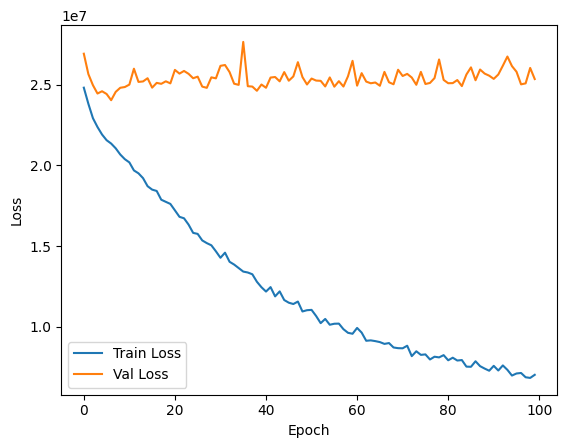

In [81]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
for e in tqdm(range(num_epochs)):
    model.train()

    steps_train = 0
    steps_val = 0
    tot_train_loss = 0
    tot_val_loss = 0

    for (x, y) in train_loader:
        (x, y) = (x.to(device), y.to(device))
        pred = model(x).reshape(-1)
        #print(f'pred: {pred.shape}')
        #print(y.shape)
        loss = loss_function(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tot_train_loss += loss.item()
        steps_train += 1

    train_loss_per_epoch = tot_train_loss / steps_train
    train_losses.append(train_loss_per_epoch)

    with torch.no_grad():
        model.eval()

        for (x, y) in val_loader:
            (x, y) = (x.to(device), y.to(device))
            pred = model(x).reshape(-1)
            batch_loss = loss_function(pred, y)
            tot_val_loss += batch_loss.item()  # Use item() to get the scalar value
            steps_val += 1


    val_loss_per_epoch = tot_val_loss / steps_val
    val_losses.append(val_loss_per_epoch)

    print(f"\nEpoch {e + 1} => Train Loss: {train_loss_per_epoch}, Val Loss: {val_loss_per_epoch}")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [92]:
len(val_targets)

14779

In [93]:
import random

# Generate a random list of integers within the range of 0 to 1000
random_list = [random.randint(0, 1000) for _ in range(14779)]  # Change 10 to the desired length of the list

print(len(random_list))

14779


In [83]:
tot_pred = []
with torch.no_grad():
        model.eval()

        for (x, y) in val_loader:
            (x, y) = (x.to(device), y.to(device))
            pred = model(x).reshape(-1)
            tot_pred.extend(pred.tolist())

In [84]:
tot_pred

[-2.4027795791625977,
 468.6556091308594,
 245.53256225585938,
 81.83721160888672,
 118.22763061523438,
 81.75415802001953,
 910.093994140625,
 804.772705078125,
 90.48428344726562,
 79.64398956298828,
 365.4203186035156,
 175.04014587402344,
 841.1454467773438,
 325.72491455078125,
 5.074930191040039,
 568.1865844726562,
 80.66065216064453,
 942.430419921875,
 81.93647766113281,
 81.3012466430664,
 259.5382385253906,
 325.2705993652344,
 80.5803451538086,
 233.72891235351562,
 817.884765625,
 7.81571102142334,
 82.08641815185547,
 81.4494400024414,
 1046.291748046875,
 532.2084350585938,
 876.6396484375,
 970.2673950195312,
 590.0873413085938,
 81.0900650024414,
 557.8154907226562,
 11.54944896697998,
 549.5289916992188,
 665.9012451171875,
 81.86984252929688,
 755.9263916015625,
 81.2434310913086,
 187.40545654296875,
 82.0874252319336,
 590.0873413085938,
 88.80817413330078,
 871.9405517578125,
 892.1136474609375,
 11.42197322845459,
 1317.8511962890625,
 80.51451873779297,
 97.8338

/tmp/ipykernel_949033/1662821723.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=tot_pred, shade=True, label='Distribution 2')
/tmp/ipykernel_949033/1662821723.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=val_targets, shade=True, label='Distribution 1')


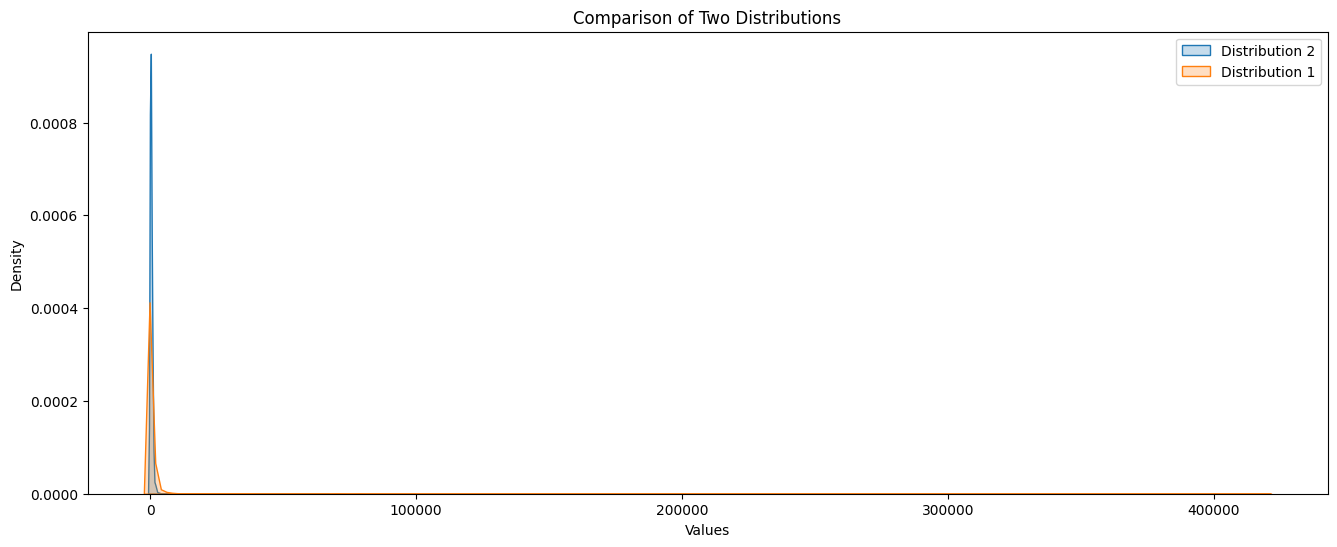

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data1' and 'data2' are your two numerical datasets
plt.figure(figsize=(16, 6))  # Adjust the width and height as needed

# Plotting KDEs for both datasets on the same plot
sns.kdeplot(data=tot_pred, shade=True, label='Distribution 2')
sns.kdeplot(data=val_targets, shade=True, label='Distribution 1')

plt.title('Comparison of Two Distributions')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()  # Show legend indicating the distributions
plt.show()


In [90]:
print(f'mean_actual = {np.array(val_targets).mean()}, mean_predicted = {np.array(tot_pred).mean()}')
print(f'std_actual = {np.array(val_targets).std()}, std_predicted = {np.array(tot_pred).std()}')

mean_actual = 777.0876243318222, mean_predicted = 471.1765089633218
std_actual = 5226.573464927433, std_predicted = 1623.839500566406


In [91]:
from sklearn.metrics import mean_squared_error

array1 = np.array(val_targets)  # Replace with your first array
array2 = np.array(tot_pred)  # Replace with your second array

rmse = np.sqrt(mean_squared_error(array1, array2))

print("RMSE:", rmse)

RMSE: 5046.6443456210145
